# Feature Matching

## Difference to template matching
Template matching required an exact image of the image one was looking for. So a sub-image in the larger image

## Definition feature matching
* extracts the defining key features from an input image (using ideas from corner, edge, and contour detection)
* distance calculation is used to find all the matches in a secondary image
* Benefit: An exact image of the searched sub-image is not required anymore

## Methods
1. Brute-Force Matching with ORB Descriptors
2. Brute-Force Matching with SIFT descriptors and ratio test
3. FLANN based matcher

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage as ski

In [3]:
def display_img(img, cmap="gray"):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap)

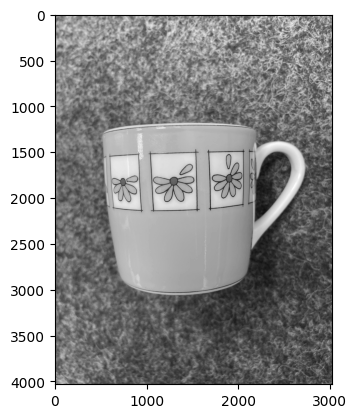

In [4]:
cup = cv2.imread("DATA/cup_img.jpeg", 0)
plt.imshow(cup, cmap="gray")

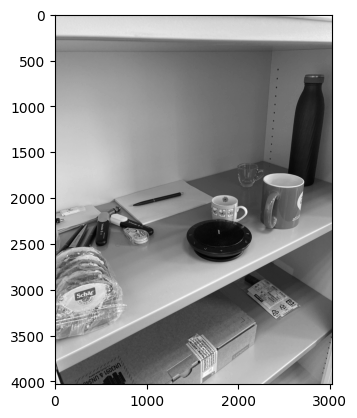

In [5]:
search_img = cv2.imread("DATA/search_img.jpeg", 0)
plt.imshow(search_img, cmap="gray")

# Method 1: Brute-Force Matching with ORB Features

In [7]:
# Create detection objects
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(cup, None)
kp2, des2 = orb.detectAndCompute(search_img, None)

In [8]:
# Create Matching object
brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [9]:
# Check where the matches occur
matches = brute_force.match(des1, des2)

# Sort the matches in order of their distance
matches = sorted(matches, key=lambda x: x.distance)

In [11]:
# investigate the matches a little more
single_match = matches[0]
single_match.distance

44.0

In [12]:
# Use the drawing function of cv2
# It does automatically stitch together the target and the search image and draws lines
cup_matches = cv2.drawMatches(cup, kp1, search_img, kp2, matches[:25], None, flags=2)

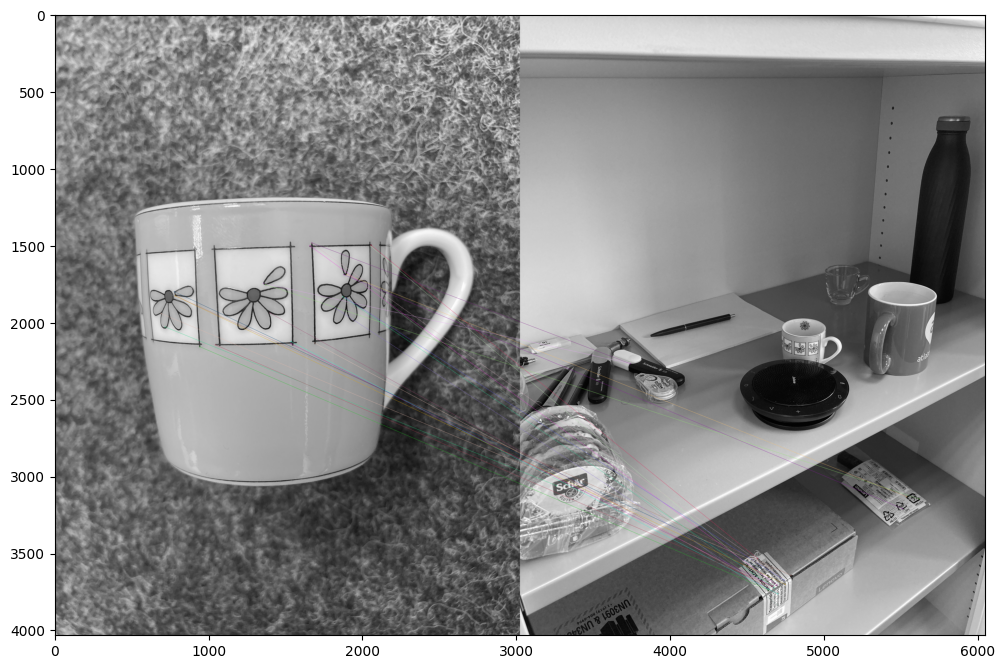

In [14]:
display_img(cup_matches)
# Observation: 
#  That does not work very well, because the image does not really look like the target image
#  The object is not completely visible in the target image
#  also the angle is different and you can see more in the cup image than there is observable in the target image

# Method 2: Brute-Force Matching using SIFT descriptors and ratio test
## Definition SIFT
Scale Invariant Featuer Transform

Works well if the image scale changes a lot between matching and goal image

In [18]:
# TODO: Explain SIFT better in Readme
sift = cv2.SIFT_create() # Creating a SIFT object
kp1, des1 = sift.detectAndCompute(cup, None)
kp2, des2 = sift.detectAndCompute(search_img, None)

In [19]:
# Calculate and compare the matches
brute_force_sift = cv2.BFMatcher()
matches = brute_force_sift.knnMatch(des1, des2, k=2)  # Find the top k matches (in this case 2)

In [20]:
matches # Pairs -> first column, first best match, second columg, second best match

((< cv2.DMatch 0x7f90402b7890>, < cv2.DMatch 0x7f90402b7d50>),
 (< cv2.DMatch 0x7f90402b7130>, < cv2.DMatch 0x7f90402b7e30>),
 (< cv2.DMatch 0x7f90402b7c10>, < cv2.DMatch 0x7f90402b71f0>),
 (< cv2.DMatch 0x7f90402b7390>, < cv2.DMatch 0x7f90402b7b90>),
 (< cv2.DMatch 0x7f90402b69d0>, < cv2.DMatch 0x7f90402b7f90>),
 (< cv2.DMatch 0x7f90402b7490>, < cv2.DMatch 0x7f90402b7ed0>),
 (< cv2.DMatch 0x7f90402b73d0>, < cv2.DMatch 0x7f90402b7db0>),
 (< cv2.DMatch 0x7f90402b7cf0>, < cv2.DMatch 0x7f90402b7910>),
 (< cv2.DMatch 0x7f90402b6e30>, < cv2.DMatch 0x7f90402b7970>),
 (< cv2.DMatch 0x7f90402b72b0>, < cv2.DMatch 0x7f90402b7e90>),
 (< cv2.DMatch 0x7f90402b7770>, < cv2.DMatch 0x7f90402b7a50>),
 (< cv2.DMatch 0x7f90402b7eb0>, < cv2.DMatch 0x7f90402b7d30>),
 (< cv2.DMatch 0x7f90402b7690>, < cv2.DMatch 0x7f90402b6ef0>),
 (< cv2.DMatch 0x7f90402b6ff0>, < cv2.DMatch 0x7f90402b7430>),
 (< cv2.DMatch 0x7f90402b7b70>, < cv2.DMatch 0x7f90402b75b0>),
 (< cv2.DMatch 0x7f90402b7a30>, < cv2.DMatch 0x7f90402b

In [21]:
good = []
# General Rule: Less Distance == Better Match
# RATIO TEST: Because -> Ratio Match1 < 75% Match2
for match1, match2 in matches:
    # If match1_distance is less than 75 % of match 2 distance
    # then descriptor was a good match -> keep it
    if match1.distance < 0.75 * match2.distance:
        good.append([match1])

In [25]:
print("We identified " + str(len(good)) + " good matches from a total number of " + str(len(matches)) + ".")

We identified 93 good matches from a total number of 12955.


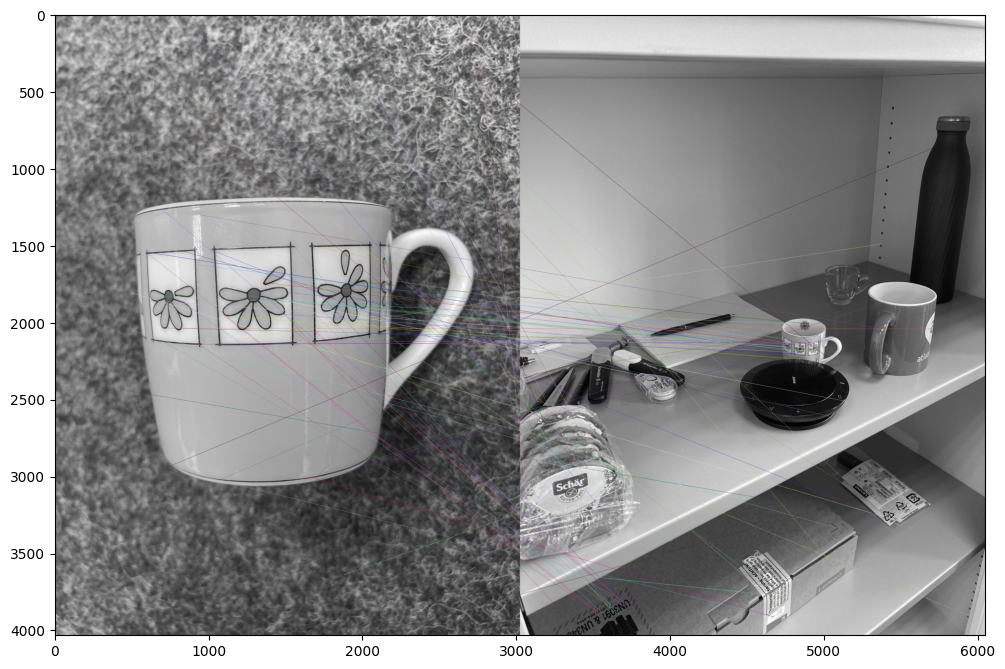

In [26]:
# check how they performed
sift_matches = cv2.drawMatchesKnn(cup, kp1, search_img, kp2, good, None, flags=2)
display_img(sift_matches)
# Observation: This worked way better, even though there are some of missmatches still in the matches

# FLANN based matcher

In [27]:
sift = cv2.SIFT_create() # Creating a SIFT object
kp1, des1 = sift.detectAndCompute(cup, None)
kp2, des2 = sift.detectAndCompute(search_img, None)

In [28]:
# FLANN parameter definition
# Flann is much faster than the Brute-Force algos but it only finds the approximate nearest neighbors which is a good result but often not the best
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

In [29]:
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [30]:
# Create a mask for better drawing
matchesMask = [[0,0] for i in range(len(matches))]
# Ratio test
# General Rule: Less Distance == Better Match
# RATIO TEST: Because -> Ratio Match1 < 75% Match2
for i, (match1, match2) in matches:
    # If match1_distance is less than 75 % of match 2 distance
    # then descriptor was a good match -> keep it
    if match1.distance < 0.75 * match2.distance:
        matchesMask[i] = [1,0]

draw_params = dict(matchColor=(0,255,0), singlePointColor=(255,0,0), matchesMask=matchesMask, flags=0)

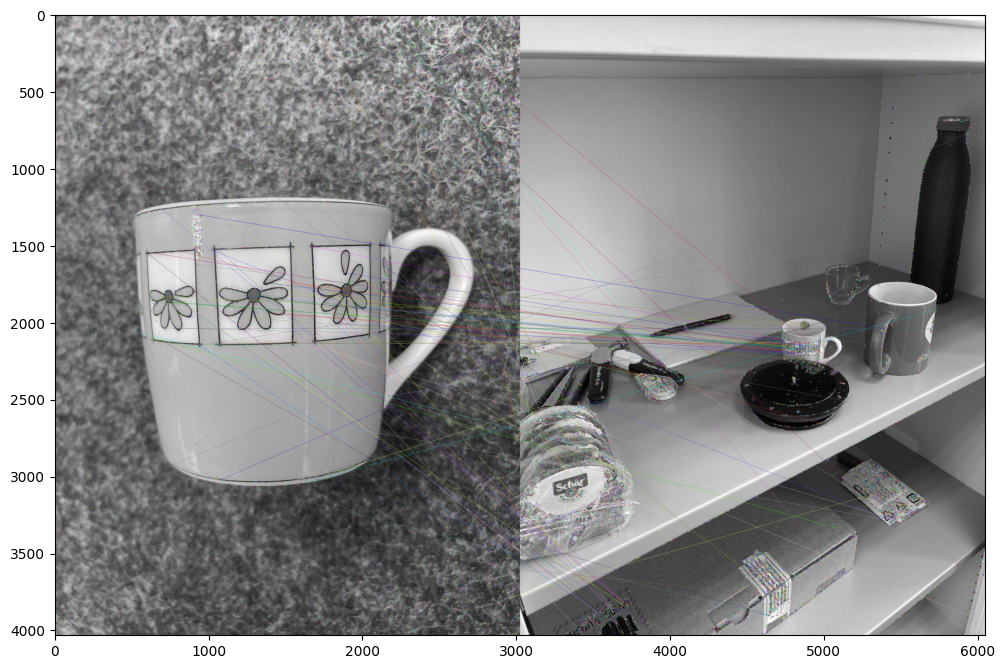

In [31]:
flann_matches = cv2.drawMatchesKnn(cup, kp1, search_img, kp2, good, None, flags=0)
display_img(flann_matches)